In [39]:
# %load ../modules/audio_preprocessing.py
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

def emphesize_signal(signal, pre_emphasis = 0.97):
    ''' Filter signal to amplify the high frequencies '''
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return emphasized_signal

def get_filter_banks(signal, sample_rate, frame_size = 0.025, frame_stride = 0.01, NFFT = 512, nfilt = 40):
    ''' Calculate filter banks from signal '''
    emphasized_signal = emphesize_signal(signal)

    # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal number of samples 
    # without truncating any samples from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    frames *= np.hamming(frame_length)
    # frames *= 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1))  # Explicit Implementation **

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    #  Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

def get_mfcc(filter_banks, num_ceps = 12):
    ''' Calculate MFCC from filter banks '''
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    return mfcc

def normalize_mfcc(mfcc, filter_banks, cep_lifter = 100):
    ''' Normalize MFCC '''
    nframes, ncoeff = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    filter_banks -= (np.mean(filter_banks, axis=0)) # + 1e-8)
    mfcc -= (np.mean(mfcc, axis=0)) # + 1e-8)
    return mfcc

def plot_spectrogram(spectrogram, title, x_label, y_label):
    ''' Plot spectrogram '''
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.imshow(spectrogram.T, cmap=plt.cm.jet, aspect='auto')
    plt.xticks(np.arange(0, (spectrogram.T).shape[1], int((spectrogram.T).shape[1] / 4)))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.invert_yaxis()

This install of SoX cannot process .WAV files.
output_file: test.wav already exists and will be overwritten on build


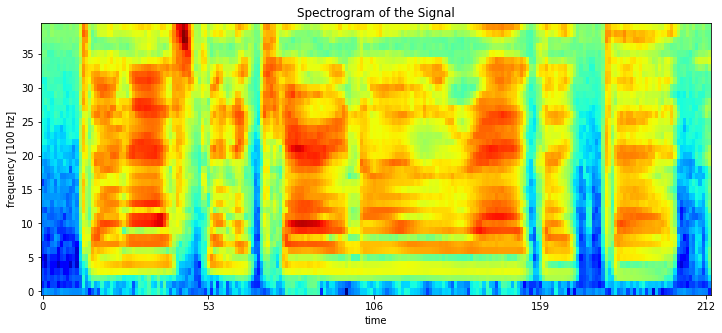

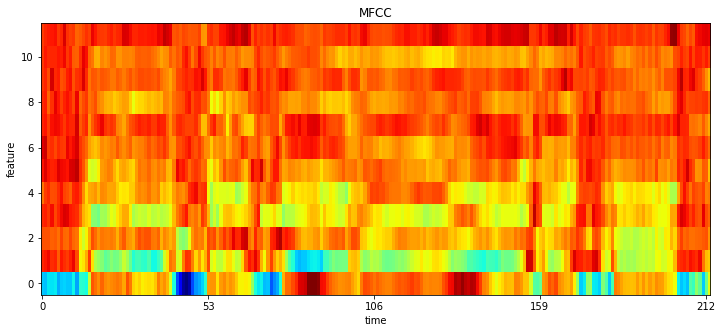

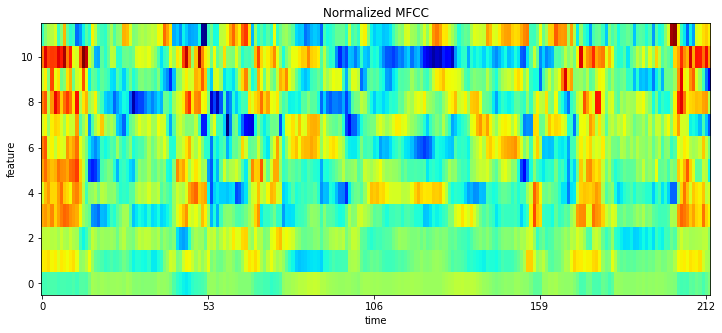

In [40]:
import sox

tfm = sox.Transformer()

tfm.build('../data/FCJF0/SA2.WAV', 'sample.wav')

# File assumed to be in the same directory
sample_rate, signal_org = scipy.io.wavfile.read('sample.wav')

# Keep the first 3.5 seconds
# signal = signal_org[int(0 * sample_rate):int( * sample_rate)]
signal = signal_org

filter_banks = get_filter_banks(signal, sample_rate)
plot_spectrogram(filter_banks, 'Spectrogram of the Signal', 'time', 'frequency [100 Hz]')

mfcc = get_mfcc(filter_banks)

plot_spectrogram(mfcc, 'MFCC', 'time', 'feature')

mfcc = normalize_mfcc(mfcc, filter_banks)

plot_spectrogram(mfcc, 'Normalized MFCC', 'time', 'feature')